In [79]:
import wfdb
import matplotlib.pyplot as plt
from constants import *
from main import *
import h5py
import librosa as lr
import matplotlib.pyplot as plt
from librosa import display
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
import os

In [123]:
def transform_undef(hypnogram):
    hypnogram[hypnogram == 0] = 5
    return hypnogram

def get_sleep_stages(record):
    stages,_,_ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    return transform_undef(stages[0:len(stages):30*200])

def get_signal(record):
    # 'F4-M1'
    signal = wfdb.rdrecord(TRAIN_PATH+record, channels=[1]).p_signal
    return signal.reshape((len(signal),))

def get_classification_input(record_list):
    X = []
    Y = np.array([])
    
    for record in record_list:
        signal = get_signal(record)
        s_stages = get_sleep_stages(record)
        
        while signal.size != 0:
            if signal[0:30*200].size != 6000:
                # remove the last element from s_stages
                s_stages = np.delete(s_stages, -1)
                pass
            else:
                # calculate spectogram (db)
                X.append(lr.power_to_db(
                    lr.feature.melspectrogram(y=signal[0:30*200], sr=200)))
            signal = signal[30*200:]
            
        Y = np.append(Y, s_stages)
    return np.array(X), Y

In [120]:
record_list = get_all_records(TRAIN_PATH, "RECORDS")

rec = record_list[:10]

In [122]:
X, Y = get_classification_input(rec)
print(X.shape, "\t", Y.shape)
Y

(9030, 128, 12) 	 (9030,)


array([5., 5., 5., ..., 2., 2., 2.])

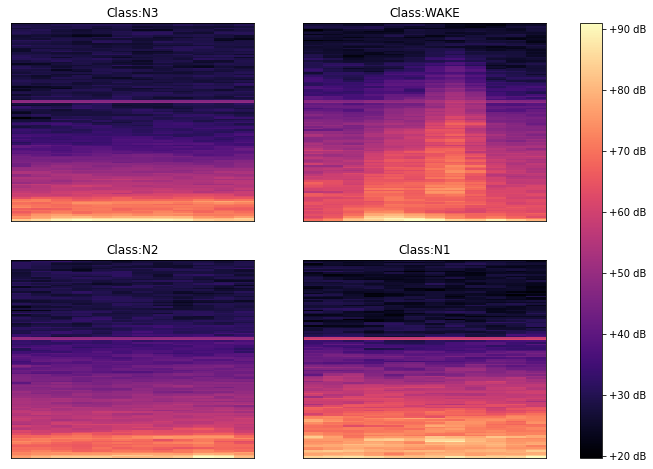

In [187]:
# Visualize the data

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
ax0, ax1, ax2, ax3 = axes.flatten()

img=lr.display.specshow(X[101], ax=ax0, sr=200)
ax0.set_title("Class:{}".format(TICK_LABELS.get(Y[101])))

lr.display.specshow(X[2], ax=ax1, sr=200)
ax1.set_title("Class:{}".format(TICK_LABELS.get(Y[2])))

lr.display.specshow(X[80], ax=ax2, sr=200)
ax2.set_title("Class:{}".format(TICK_LABELS.get(Y[80])))

lr.display.specshow(X[20], ax=ax3, sr=200)
ax3.set_title("Class:{}".format(TICK_LABELS.get(Y[20])))

fig.colorbar(img, ax=axes, format="%+2.f dB")

# Encode the classes

In [114]:
# get the classes first
s = np.array([])
s_stages = get_sleep_stages("tr03-0005/tr03-0005")
f_stages = get_sleep_stages("tr03-0005/tr03-0005")

s = np.append(s,s_stages)
s = np.append(s,f_stages)
len(s)

1716

In [9]:
s_stages = s_stages.reshape((len(s_stages),1))

encoder = OneHotEncoder().fit(s_stages)
s_classes = encoder.transform(s_stages).toarray()

s_classes.shape

(858, 5)

In [10]:
class Model():
    def __init__(self):
        self.model = tf.keras.Sequential([
            layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", padding="same",
                         input_shape=[128, 12, 1]),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Conv2D(filters=8, kernel_size=(2,2), activation="relu",padding="same"),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Flatten(),
            layers.Dense(100, input_shape=(96,), activation="relu"),
            layers.Dense(5, activation="softmax")
        ])
    def get_model(self):
        return self.model

In [11]:
model = Model()
model = model.get_model()

2022-01-17 11:31:23.766374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 11:31:23.766396: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 11:31:23.766409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-17 11:31:23.766572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
checkpoint_path = "/my_classifier/cp.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')